In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

In [2]:
def plot_learning_curve(model, X, y, X_train=None, X_val=None, y_train=None, y_val=None):

  if X_train is None: 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=27)
  train_errors, val_errors = [], []
  train_size = np.linspace(10, len(X_train), 10).astype(int)
  for m in train_size:
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)

    train_errors.append(f1_score(y_train[:m], y_train_predict, average='macro'))
    val_errors.append(f1_score(y_val, y_val_predict, average= 'macro'))
  plt.grid()
  plt.plot(train_size, train_errors, 'r', label= 'Training Error')
  plt.plot(train_size, val_errors, 'b', label = 'Validation Error')
  plt.ylabel('F1 Macro Score')
  plt.xlabel('Training Example Size')
  plt.legend(loc='best')

In [3]:
def plot_learning_curve_hyper(df, x_axis_label, y_axis_label, title, ax=None, ylim=None):
  x = []
  for ele in df.params:
    for k, v in ele.items():
      x.append(str(v))
  if ax is None:
    _, ax = plt.subplots(figsize=(14, 10))

  ax.set_title(title)
  if ylim is not None:
    ax.set_ylim(*ylim)
  ax.set_xlabel(x_axis_label)
  ax.set_ylabel(y_axis_label)
  ax.grid()
  ax.fill_between(
    x,
    (df['mean_train_score'] - df['std_train_score']).values,
    (df['mean_train_score'] + df['std_train_score']).values,
    alpha=0.1,
    color="r",
    )
  ax.fill_between(
    x,
    (df['mean_test_score'] - df['std_test_score']).values,
    (df['mean_test_score'] + df['std_test_score']).values,
    alpha=0.1,
    color="g",
    )
  ax.plot(x, df['mean_train_score'], "x-", color = 'r', label = 'Training Score')
  ax.plot(x, df['mean_test_score'], "x-", color = 'g', label = 'Cross-validation Score')
  ax.legend(loc="best")

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Wine_Classification'

/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Wine_Classification


In [6]:
import pandas as pd

df = pd.read_csv('data/winequality-white.csv', sep= ';')

In [7]:
X = df.drop('quality', axis=1)
y = df['quality']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                    random_state=27, stratify = y)

In [9]:
print(y_train.value_counts())
print(y_test.value_counts())

6    1648
5    1093
7     660
8     131
4     122
3      15
9       4
Name: quality, dtype: int64
6    550
5    364
7    220
8     44
4     41
3      5
9      1
Name: quality, dtype: int64


In [10]:
normal_col = ['fixed acidity', 'citric acid', 'total sulfur dioxide', 'pH',
              'alcohol', 'free sulfur dioxide', 'density']
skewd_col = ['volatile acidity', 'residual sugar', 'chlorides', 
            'sulphates']

In [11]:
#Make Copy of X_train and X_test
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

In [19]:
X_train_stand.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [22]:
#Make Pipelines for data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

normal_pipeline = Pipeline(steps = [('scale', StandardScaler())])
skewd_pipline = Pipeline(steps = [('sk_scale', PowerTransformer())])
discret_pipline = Pipeline(steps = [('dist_t', KBinsDiscretizer(n_bins=4, strategy= 'quantile'))])

full_preprocessor = ColumnTransformer(transformers=[
        ('normal_transform', normal_pipeline, normal_col),
        ('skewd_transform', skewd_pipline, skewd_col)])

X_train_stand = full_preprocessor.fit_transform(X_train_stand)
X_test_stand = full_preprocessor.transform(X_test_stand)

In [ ]:
#Try Quick and Dirty SVM Classifier on unprocessed Data
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm_clf_raw = SVC(random_state=0)

svm_clf_raw.fit(X_train, y_train)

y_pred_raw = svm_clf_raw.predict(X_test)

print(f'Classification report with naive SVM using unprocessed data:\n {classification_report(y_pred_raw, y_test, zero_division=1)}')

Classification report with naive SVM using unprocessed data:
               precision    recall  f1-score   support

           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       0.07      0.41      0.12        64
           6       0.95      0.45      0.61      1161
           7       0.00      1.00      0.00         0
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0

    accuracy                           0.45      1225
   macro avg       0.15      0.84      0.10      1225
weighted avg       0.90      0.45      0.58      1225



In [ ]:
# labels that can not be predicted by SVM model
set(y_test) - set(y_pred_raw)

{3, 4, 7, 8, 9}

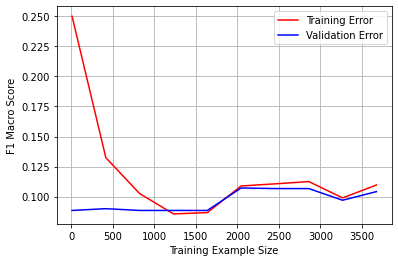

In [ ]:
plot_learning_curve(svm_clf_raw, X, y, X_train = X_train, X_val = X_test, y_train = y_train, y_val = y_test)

In [ ]:
#Try Quick and Dirty SVM Classifier on Processed Data
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm_clf_p = SVC(random_state=0)

svm_clf_p.fit(X_train_stand, y_train)

y_pred_p = svm_clf_p.predict(X_test_stand)

print(f'Classification report with naive SVM using processed data:\n {classification_report(y_pred_p, y_test, zero_division=1)}')

Classification report with naive SVM using processed data:
               precision    recall  f1-score   support

           3       0.00      1.00      0.00         0
           4       0.05      0.50      0.09         4
           5       0.57      0.60      0.59       349
           6       0.76      0.55      0.64       759
           7       0.29      0.57      0.38       113
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0

    accuracy                           0.56      1225
   macro avg       0.24      0.74      0.24      1225
weighted avg       0.66      0.56      0.60      1225



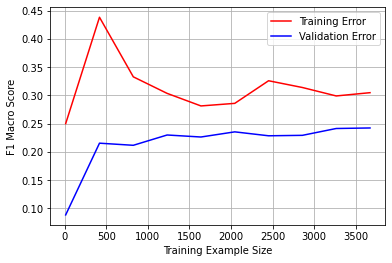

In [ ]:
plot_learning_curve(svm_clf_p, X, y, X_train = X_train_stand, X_val = X_test_stand, y_train = y_train, y_val = y_test)

In [ ]:
# labels that can not be predicted by SVM model
set(y_test) - set(y_pred_p)

{3, 8, 9}

In [ ]:
X_train_stand_df = pd.DataFrame(X_train_stand, columns=X_train.columns)
X_test_stand_df = pd.DataFrame(X_test_stand, columns=X_test.columns)

In [ ]:
# Feature Selection using Anova Analysis
from sklearn.feature_selection import SelectKBest, f_classif

selection = SelectKBest(f_classif, k=6)



selection.fit(X_train_stand_df, y_train)

print(f'List of features inputed:\n {selection.feature_names_in_}\n')
print(f'List of features selected:\n {X_train_stand_df.columns[selection.get_support()]}')

X_train_selected = selection.transform(X_train_stand_df)
X_test_selected = selection.transform(X_test_stand_df)

List of features inputed:
 ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol']

List of features selected:
 Index(['citric acid', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'sulphates'],
      dtype='object')


In [ ]:
#Try Quick and Dirty SVM Classifier on Processed Data and Feature Selected
from sklearn.svm import SVC
from sklearn.metrics import classification_report

svm_clf_ps = SVC(random_state=0)

svm_clf_ps.fit(X_train_selected, y_train)

y_pred_ps = svm_clf_ps.predict(X_test_selected)

print(f'Classification report with naive SVM using processed data:\n {classification_report(y_pred_ps, y_test, zero_division=1)}')

Classification report with naive SVM using processed data:
               precision    recall  f1-score   support

           3       0.00      1.00      0.00         0
           4       0.05      1.00      0.09         2
           5       0.55      0.60      0.57       333
           6       0.77      0.53      0.62       798
           7       0.21      0.50      0.29        92
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0

    accuracy                           0.55      1225
   macro avg       0.22      0.80      0.23      1225
weighted avg       0.66      0.55      0.59      1225



In [ ]:
# labels that can not be predicted by SVM model
set(y_test) - set(y_pred_ps)

{3, 8, 9}

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf = SVC(random_state = 0)
#Check for optimal Kernel

param_grid = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'degree': [i for i in range(6,12)]}]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=4, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=4, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'degree': [6, 7, 8, 9, 10, 11],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
# Tested for higher degree polynomial degree: yet rbf kernel is outperforming
grid_search.best_params_

{'degree': 9, 'kernel': 'poly'}

In [ ]:
df_kernel = pd.DataFrame(grid_search.cv_results_)
kernel_model = grid_search.best_estimator_

In [ ]:
y_pred_kernel = kernel_model.predict(X_test_stand)
print(f'Classification Report on Test Data Using Poly Kernel:\n {classification_report(y_pred_kernel, y_test)}')

Classification Report on Test Data Using Poly Kernel:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.24      0.36      0.29        28
           5       0.24      0.71      0.35       121
           6       0.90      0.51      0.66       967
           7       0.25      0.65      0.36        84
           8       0.16      0.39      0.23        18
           9       0.00      0.00      0.00         4

    accuracy                           0.53      1225
   macro avg       0.26      0.38      0.27      1225
weighted avg       0.76      0.53      0.59      1225



In [ ]:
# labels that can not be predicted by SVM model
set(y_test) - set(y_pred_kernel)

set()

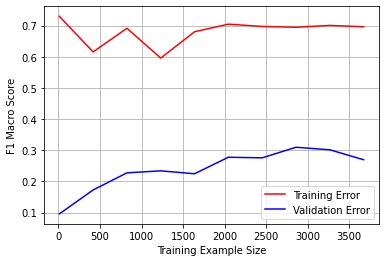

In [ ]:
plot_learning_curve(kernel_model, X, y, X_train = X_train_stand, X_val = X_test_stand, y_train= y_train, y_val = y_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Exploring only Kernel Parameters

clf_ker = SVC(random_state = 0)
#Check for optimal Kernel

param_grid = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid_search = GridSearchCV(clf_ker, param_grid = param_grid, cv=4, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=4, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
df_kernel_only = pd.DataFrame(grid_search.cv_results_)

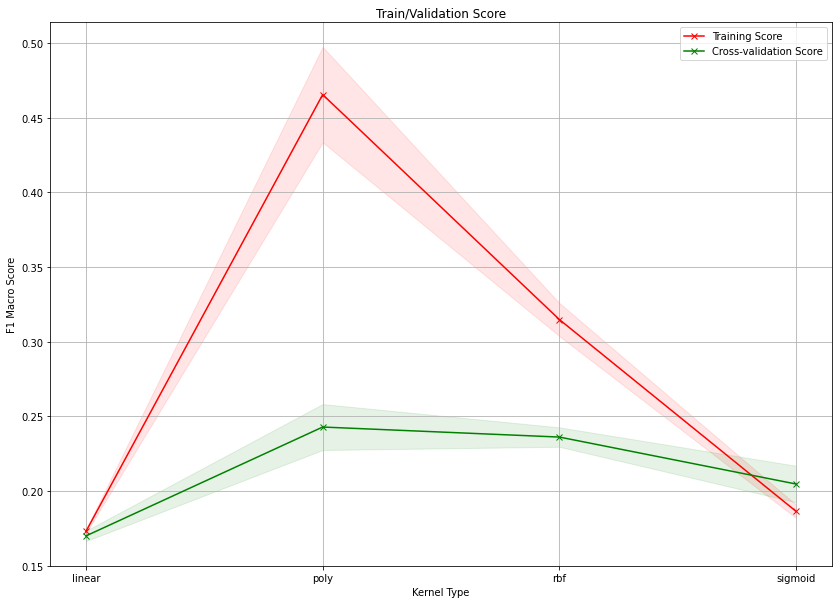

In [ ]:
plot_learning_curve_hyper(df_kernel_only, 'Kernel Type', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = SVC(random_state = 0)
#Check for optimal C

param_grid = [{'C': np.arange(7, 9, 0.2).round(2)}]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=4, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=4, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'C': array([7. , 7.2, 7.4, 7.6, 7.8, 8. , 8.2, 8.4, 8.6, 8.8])}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
df_c = pd.DataFrame(grid_search.cv_results_)

{'C': 7.8}


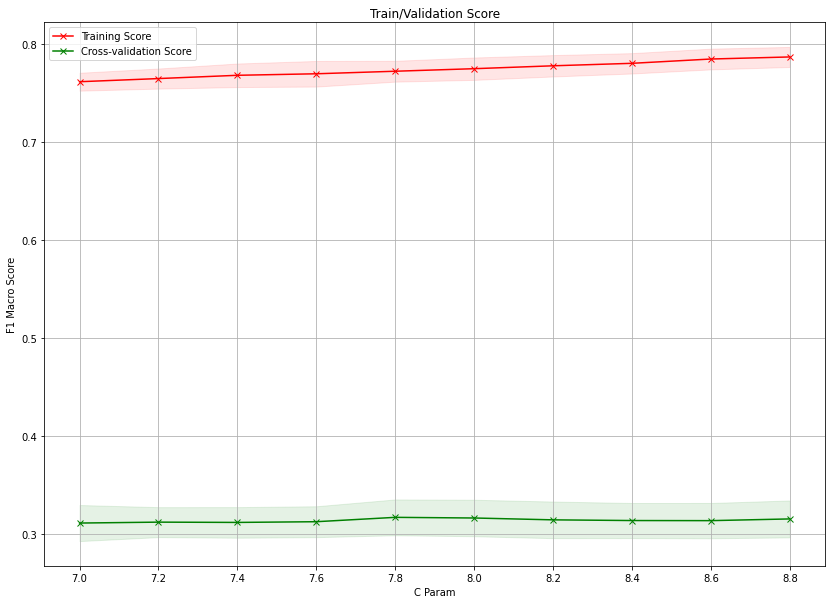

In [ ]:
plot_learning_curve_hyper(df_c, 'C Param', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = SVC(random_state = 0)
#Check for optimal gama

param_grid = [{'gamma': ['scale', 'auto']}]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=4, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=4, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'gamma': ['scale', 'auto']}], return_train_score=True,
             scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
df_gamma = pd.DataFrame(grid_search.cv_results_)

{'gamma': 'auto'}


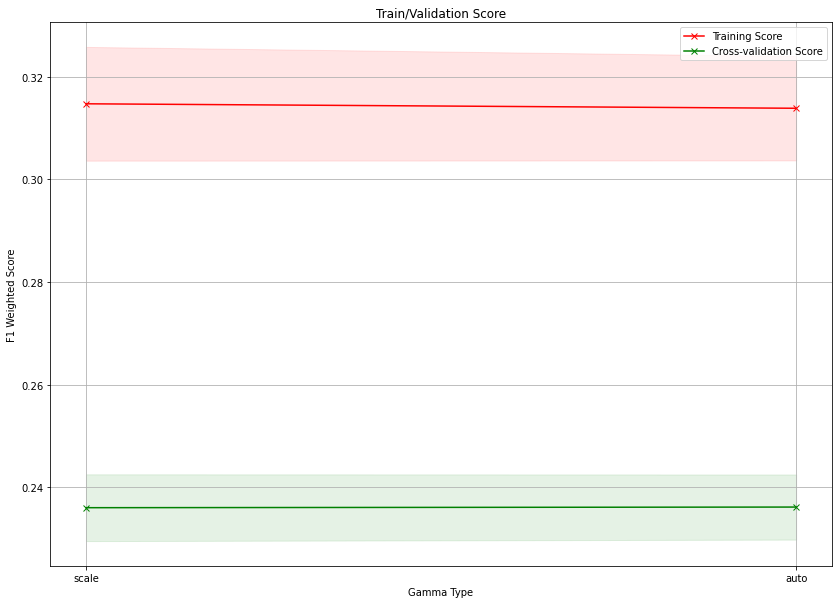

In [ ]:
plot_learning_curve_hyper(df_gamma, 'Gamma Type', 'F1 Weighted Score', 'Train/Validation Score')

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = SVC(random_state = 0)
#Check for optimal gama

param_grid = [{'class_weight': ['balanced', None]}]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=4, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=4, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'class_weight': ['balanced', None]}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
df_class_weight = pd.DataFrame(grid_search.cv_results_)

{'class_weight': 'balanced'}


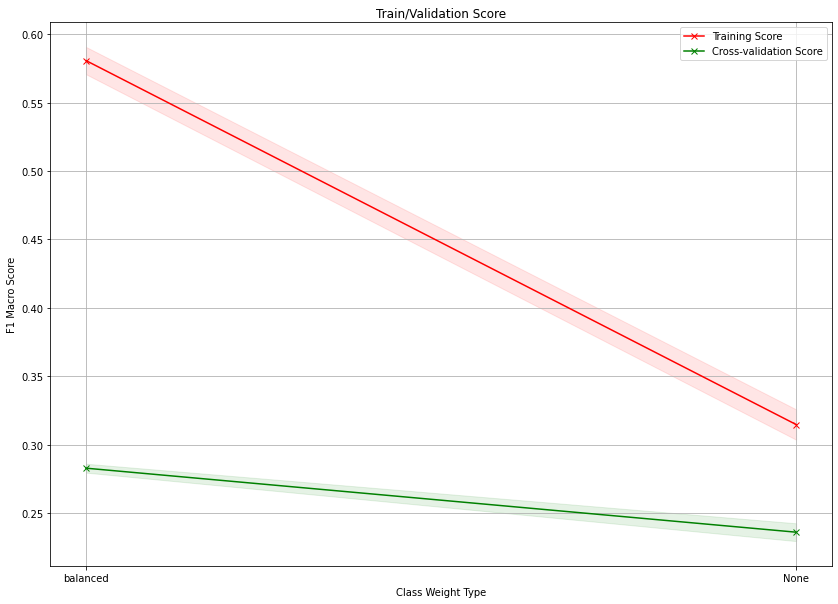

In [ ]:
plot_learning_curve_hyper(df_class_weight, 'Class Weight Type', 'F1 Macro Score', 'Train/Validation Score')

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = SVC(random_state = 0)


param_grid = [{'class_weight': ['balanced', None],
               'C': np.arange(5, 8, 0.2).round(2),
               'kernel': ['rbf'],
               'gamma': ['scale', 'auto']}]

grid_search = GridSearchCV(clf, param_grid = param_grid, cv=4, n_jobs=-1,
                           scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_stand, y_train)

GridSearchCV(cv=4, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'C': array([20. , 20.2, 20.4, 20.6, 20.8]),
                          'class_weight': ['balanced', None],
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']}],
             return_train_score=True, scoring='f1_macro')

In [ ]:
print(grid_search.best_params_)
final_model = grid_search.best_estimator_

{'C': 20.2, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
from sklearn.metrics import f1_score, classification_report

y_pred_final = final_model.predict(X_test_stand)
print(f"F1 Weighted Score on Test Set: {f1_score(y_test, y_pred_final, average='macro'):.2f}")
print(f'\nClassification report on test set:\n\n {classification_report(y_test, y_pred_final, zero_division=1)}')
print(f'\nClassification report on training set:\n\n {classification_report(y_train, final_model.predict(X_train_stand), zero_division=1)}')

F1 Weighted Score on Test Set: 0.32

Classification report on test set:

               precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.20      0.37      0.26        41
           5       0.55      0.60      0.57       364
           6       0.66      0.47      0.55       550
           7       0.46      0.58      0.51       220
           8       0.30      0.55      0.38        44
           9       0.00      0.00      0.00         1

    accuracy                           0.52      1225
   macro avg       0.31      0.36      0.32      1225
weighted avg       0.56      0.52      0.53      1225


Classification report on training set:

               precision    recall  f1-score   support

           3       0.94      1.00      0.97        15
           4       0.55      1.00      0.71       122
           5       0.75      0.83      0.79      1093
           6       0.87      0.60      0.71      1648
           7    

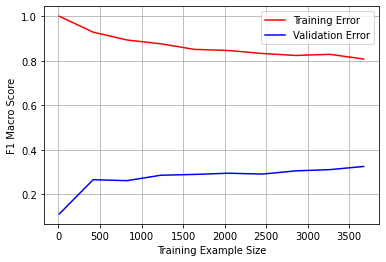

In [ ]:
plot_learning_curve(final_model, X, y, X_train = X_train_stand, X_val = X_test_stand,
                    y_train= y_train, y_val = y_test)